In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D

from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.linalg import polar

import sys
sys.path.insert(0, "..")


from utils import geometry
from utils import fileio

In [2]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched\\Tracked/20151007_1_GSV_GFPtub-CheHis_uf_8p6\\5min_int/tm_spots.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched\\Tracked/20151007_1_GSV_GFPtub-CheHis_uf_8p6\\5min_int/tm_tracks.csv', skiprows=[1,2,3])
tm_edge_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Stretched\\Tracked/20151007_1_GSV_GFPtub-CheHis_uf_8p6/5min_int/tm_edges.csv', skiprows=[1,2,3])


In [3]:
dat_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_data/20151007_1_GSV_GFPtub-CheHis_uf_8p6*/*/*/Data/*_cell_data_all*.csv'))
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_data/20151007_1_GSV_GFPtub-CheHis_uf_8p6*/*/*/Matrices'))
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'


In [4]:
micron_size=387.29
pixel_size=512


In [20]:
mat_dir

[]

In [5]:
plot_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Instant_plots\\20151007_1_GSV_GFPtub-CheHis_uf_8p6/'

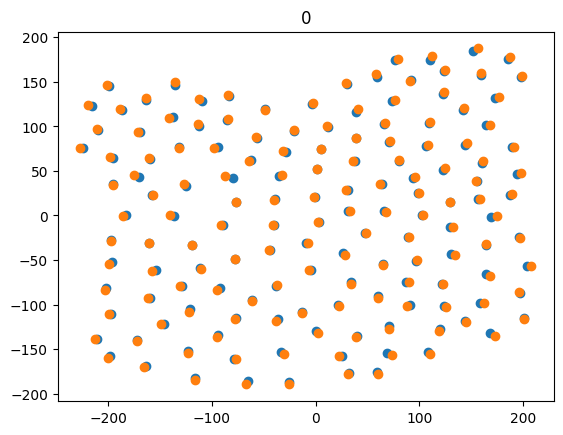

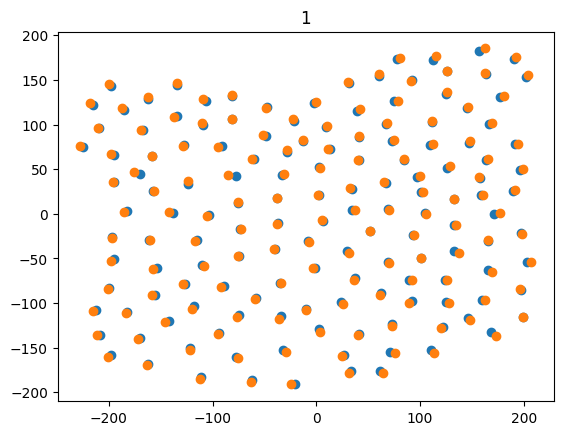

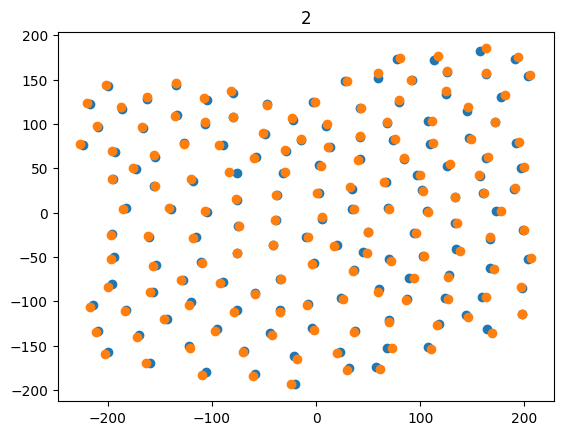

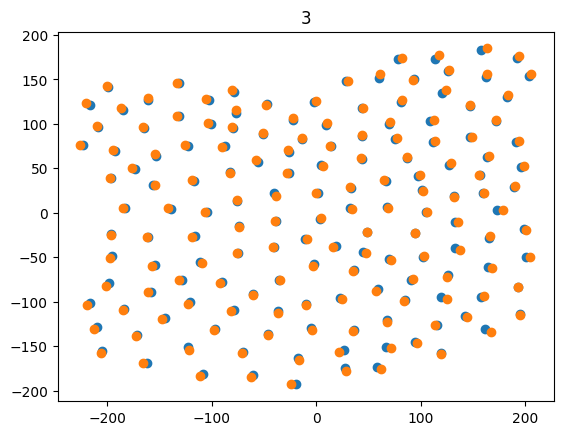

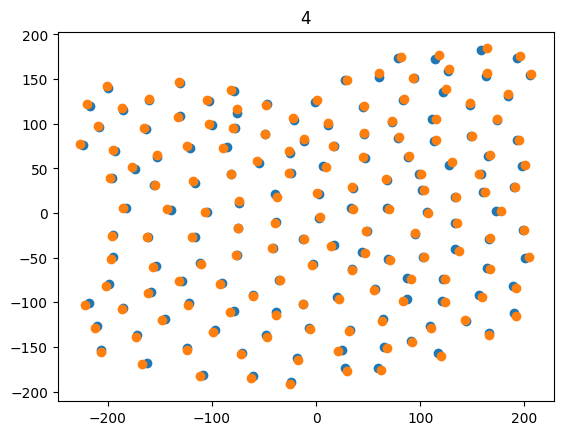

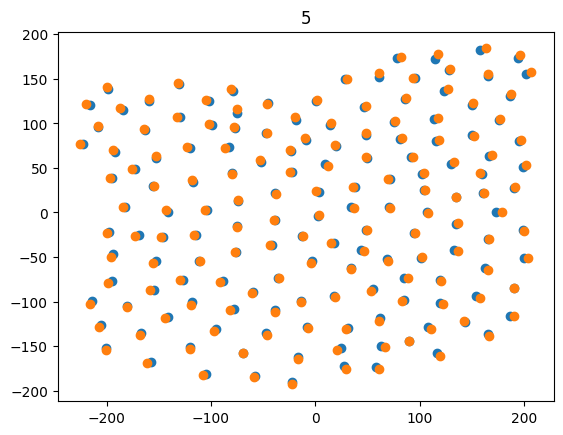

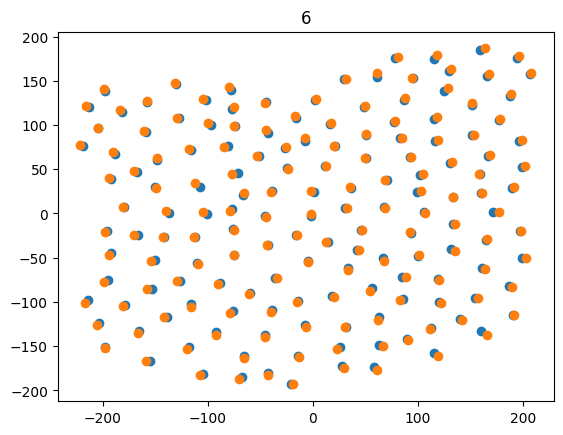

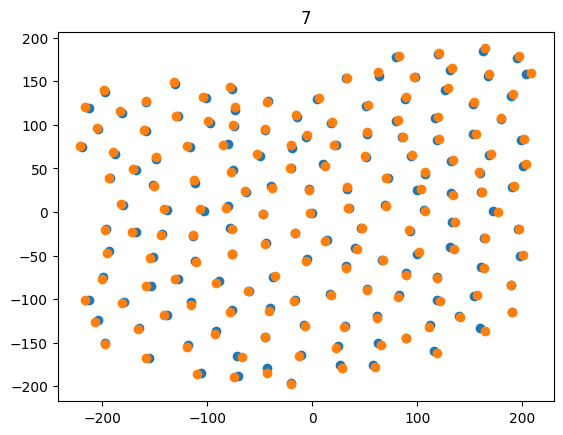

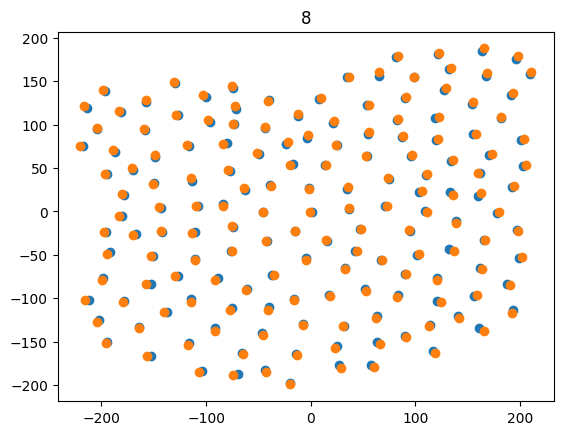

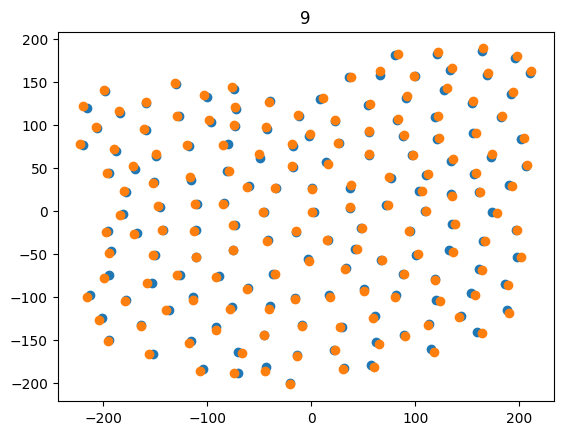

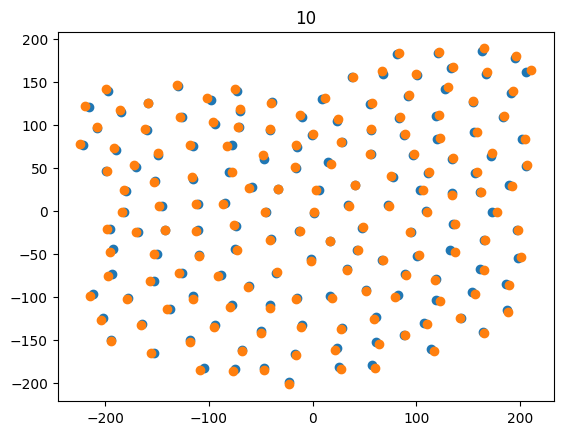

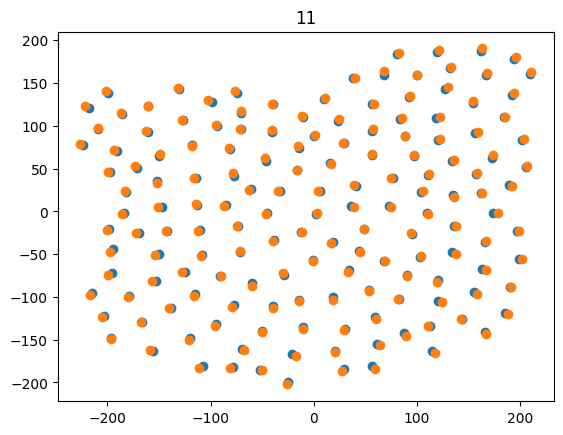

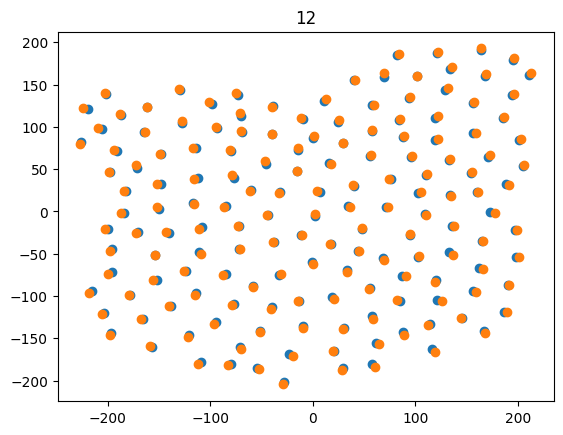

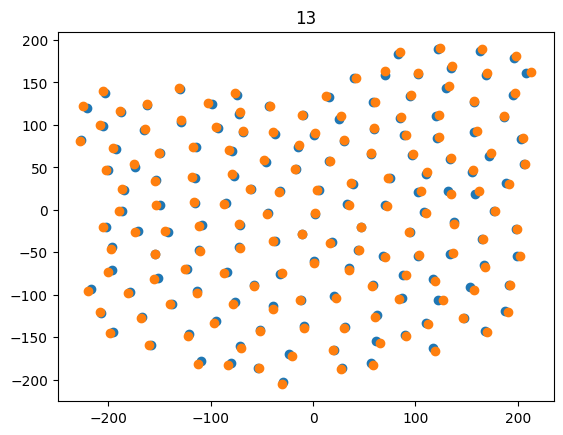

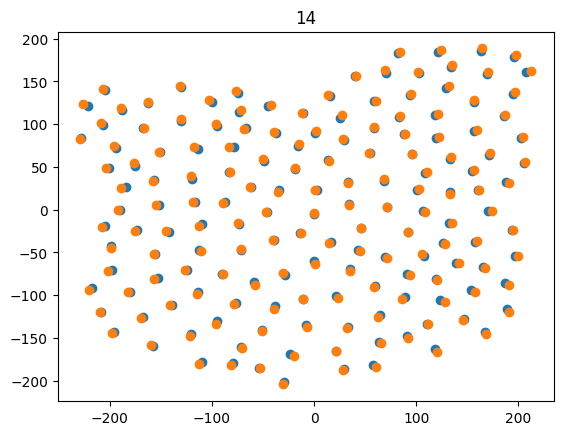

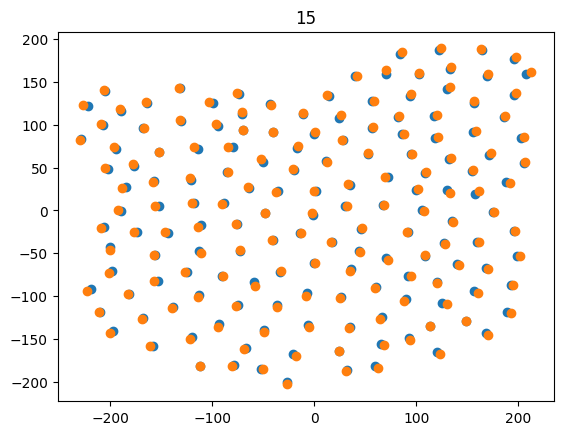

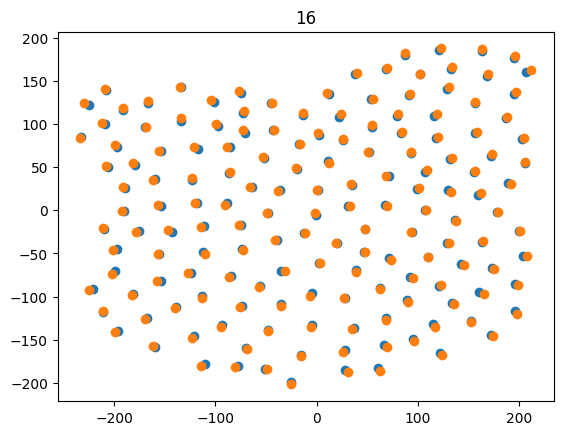

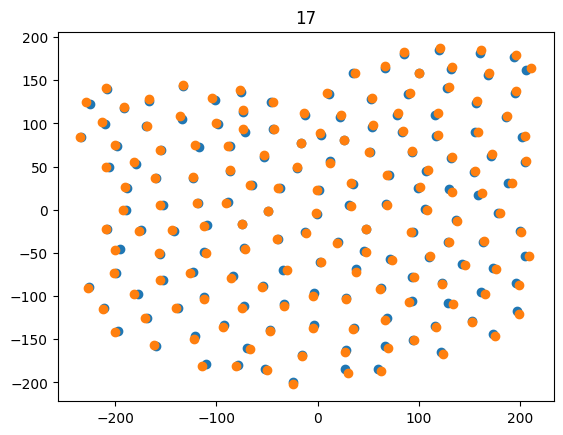

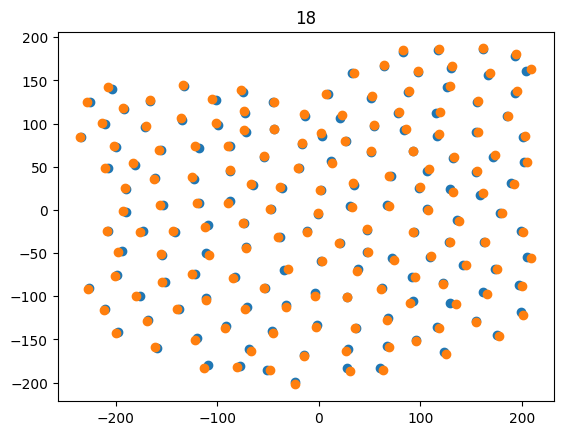

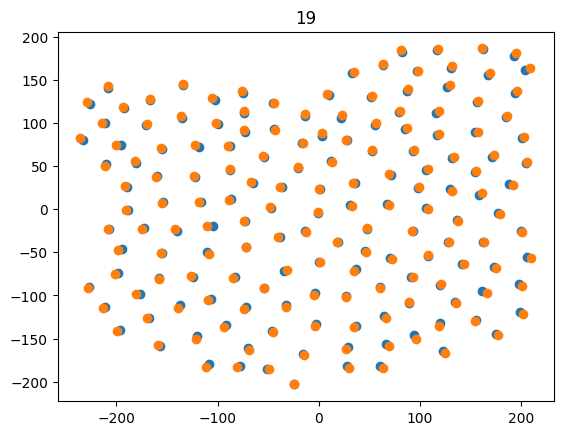

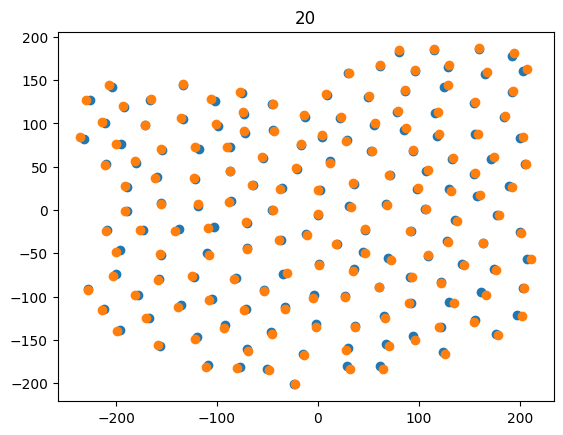

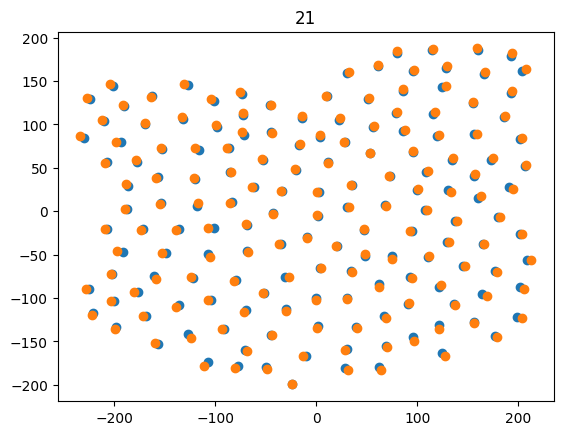

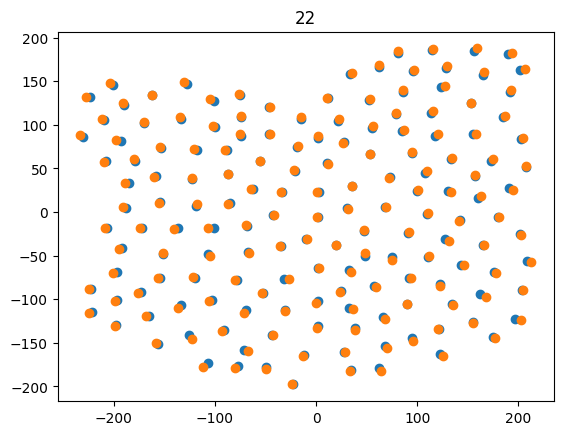

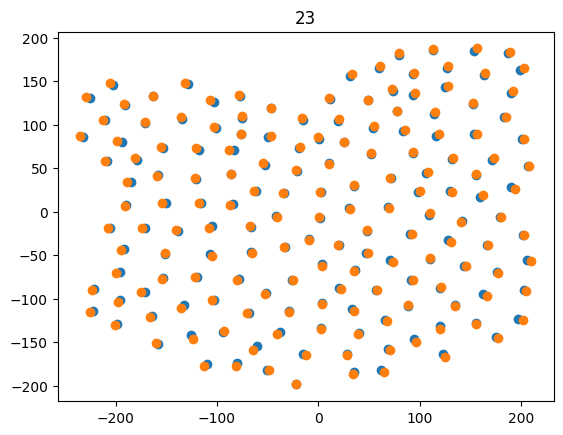

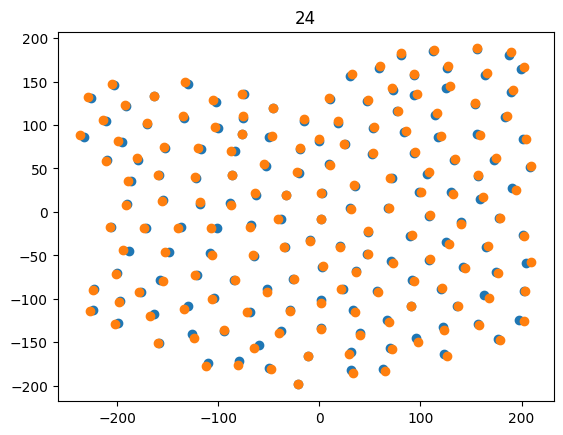

In [6]:
cols=['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'track_id', 'spot_id', 'time', 'tm_frame']
dat_df=pd.DataFrame(columns=cols)
for i in range(25):
    tm=tm_spot_dat[tm_spot_dat.FRAME==i][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    dat=pd.read_csv(dat_files[i])

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)

    scale_factor=0.45

    cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
    tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T

    plt.scatter(cc[:,0], cc[:,1])
    plt.scatter(tm_cc[:,0], tm_cc[:,1])
    plt.title(str(i))
    plt.show()

    dists=cdist(cc, tm_cc)
    min_id=np.where(dists==np.min(dists, axis=0))[1]

    dat['cc_x']=cc[:,0]
    dat['cc_y']=cc[:,1]
    dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
    dat['spot_id']=np.array(tm.ID.iloc[min_id])
    dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
    dat['time']=dat['tm_frame']*5
    


    dat_df=pd.concat([dat_df,dat], ignore_index=True)


# t_id=np.max(dat_df.track_id)
# Nc_orig=t_id

# for s in np.where(tm_track_dat.NUMBER_SPLITS>0)[0]:
#     split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]

#     edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
#     n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
#     track_a=[]
#     track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
#     index_a=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_a[-1])].index[0]
#     dat_df.track_id.loc[index_a]=t_id+1
#     track_b=[]
#     track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
#     index_b=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_b[-1])].index[0]
#     dat_df.track_id.loc[index_b]=t_id+2
#     for i in range(split+1,25):
#         n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
#         t_a=n_edges[n_edges.SPOT_SOURCE_ID==track_a[-1]].SPOT_TARGET_ID.iloc[0]
#         t_b=n_edges[n_edges.SPOT_SOURCE_ID==track_b[-1]].SPOT_TARGET_ID.iloc[0]
#         track_a.append(t_a)
#         track_b.append(t_b)
#         index_a=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_a[-1])].index[0]
#         index_b=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_b[-1])].index[0]
#         dat_df.track_id.loc[index_a]=t_id+1
#         dat_df.track_id.loc[index_b]=t_id+2
#     t_id=t_id+2

# dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
# dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))


dat_df["parent_id"] = np.nan
dat_df["divisions"] = 0

t_id=np.max(dat_df.track_id)
Nc_orig=t_id
max_splits=np.max(tm_track_dat.NUMBER_SPLITS)


for s in tm_track_dat[tm_track_dat.NUMBER_SPLITS>0].TRACK_ID:

    
    splits=np.array(tm_track_dat[tm_track_dat.TRACK_ID==s].NUMBER_SPLITS)[0]

    split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]


    edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
    n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
    track_a=[]
    track_b=[]
    track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
    track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
    
    for i in range(split+1,len(dat_files)):
        n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
        t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
        t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
        track_a=track_a+t_a
        track_b=track_b+t_b
    
    new_id_a=t_id+1
    new_id_b=t_id+2

    dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_a
    dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_b
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=s
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_a
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_b




    t_id=t_id+2

    if splits>1:
        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0])>0):
                split=np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_a]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_a
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0]) >0):
                split=np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_b]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_b
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))
dat_df['cc_x']=dat_df['cc_x']*(micron_size/pixel_size)
dat_df['cc_y']=dat_df['cc_y']*(micron_size/pixel_size)


dat_df.to_csv(save_folder+"/20151007_1_GSV_GFPtub-CheHis_uf_8p6_MP_pooled.csv",index=False)

In [23]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

In [24]:
orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]

no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
div_cells=orig_cells[orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
daughter_cells=dat_df[dat_df.cell_id_new>Nc_orig]

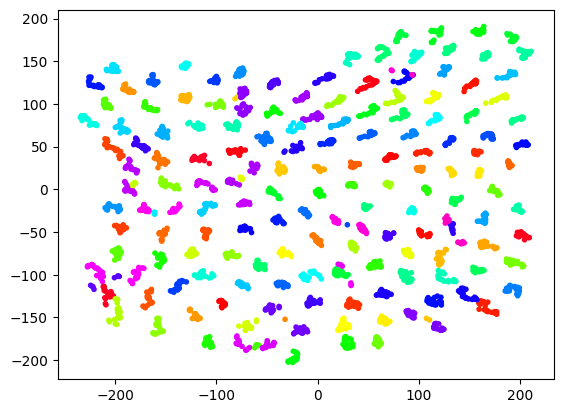

In [5]:
for i in range(1, len(dat_files)):
    plt.scatter(dat_df[dat_df.tm_frame==i].cc_x, dat_df[dat_df.tm_frame==i].cc_y, marker='.', c=dat_df[dat_df.tm_frame==i].cell_id_new,cmap='gist_rainbow', vmin=0, vmax=np.max(dat_df.cell_id_new))


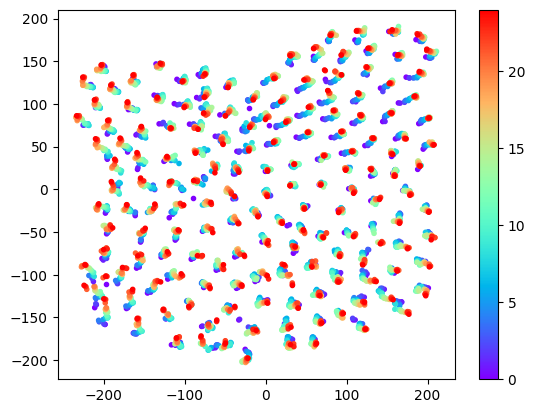

In [8]:
for i in range(np.max(dat_df.cell_id_new)):
    plt.scatter(dat_df[dat_df.cell_id_new==i].cc_x, dat_df[dat_df.cell_id_new==i].cc_y, marker='.', c=dat_df[dat_df.cell_id_new==i].tm_frame, cmap='rainbow', vmin=0, vmax=24)
plt.colorbar()

In [9]:
# orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]

# no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]

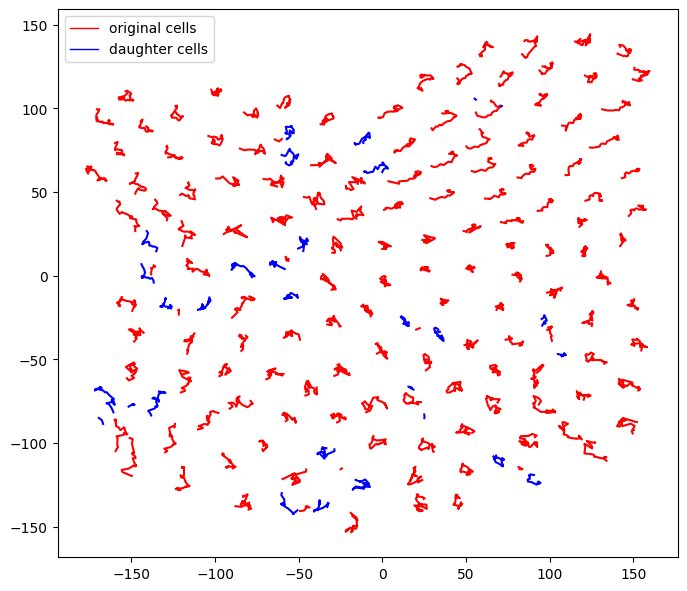

In [48]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in (np.unique(dat_df.cell_id_new)):
    plt.plot(orig_cells[orig_cells.cell_id_new==i].cc_x, orig_cells[orig_cells.cell_id_new==i].cc_y, c='red')
    plt.plot(daughter_cells[daughter_cells.cell_id_new==i].cc_x, daughter_cells[daughter_cells.cell_id_new==i].cc_y, c='blue')

ax.set_aspect('equal')
legend_elements = [Line2D([0], [0], color='r', lw=1, label='original cells'),
                  Line2D([0], [0], color='b', lw=1, label='daughter cells')]
ax.legend(handles=legend_elements)
plt.savefig(plot_dir+'/cell_tracks.png', dpi=300, bbox_inches='tight')

In [28]:
nd_t0=no_div[no_div.tm_frame==0][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]

nd_t120=no_div[no_div.tm_frame==24][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]

cc_sr=pd.merge(nd_t0, nd_t120, on='cell_id_new', suffixes=("_s", "_r"))
cc_sr['cc_dx']=cc_sr.cc_x_r-cc_sr.cc_x_s
cc_sr['cc_dy']=cc_sr.cc_y_r-cc_sr.cc_y_s

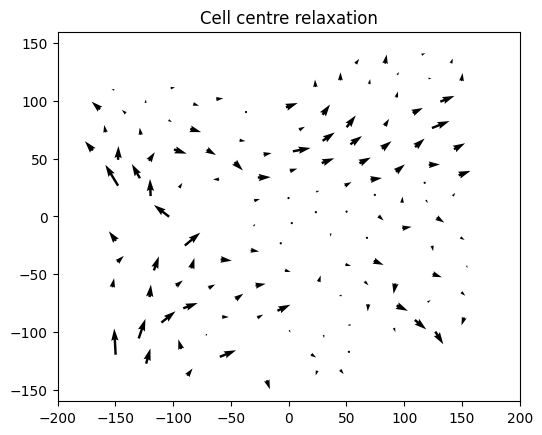

In [37]:
dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10)
plt.xlim(-200,200)
plt.ylim(-160,160)
plt.title("Cell centre relaxation")


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_relaxation.png', dpi=300, bbox_inches='tight')

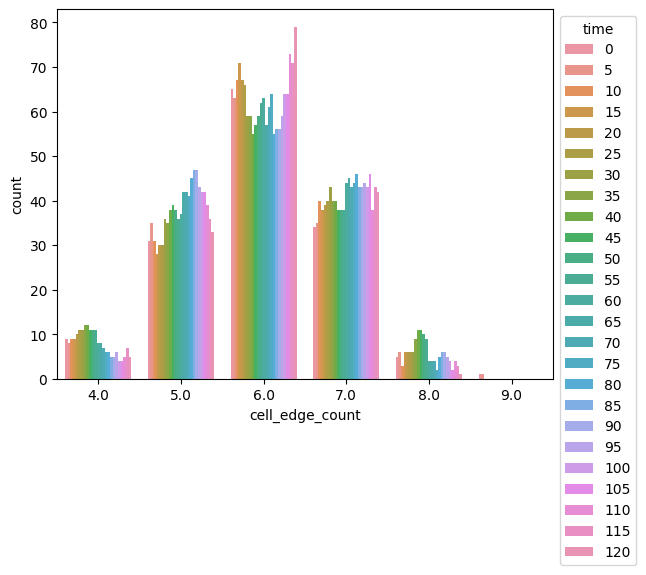

In [38]:
sns.countplot(data=dat_df,x='cell_edge_count', hue='time')
plt.legend( loc="upper left", bbox_to_anchor=(1, 1), title='time')
plt.savefig(plot_dir+'/cell_edges_hist.png', dpi=300, bbox_inches='tight')

<AxesSubplot: xlabel='time', ylabel='cell_id_new'>

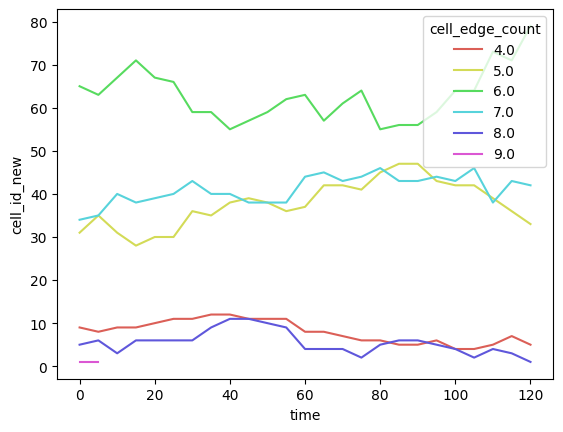

In [34]:
sns.lineplot(data=dat_df.groupby(['time', 'cell_edge_count']).count(),x='time', y='cell_id_new', hue='cell_edge_count', palette=sns.hls_palette(6))

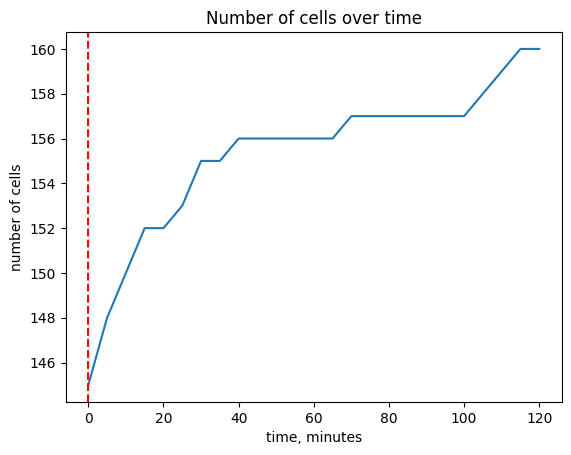

In [39]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
plt.axvline(0, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

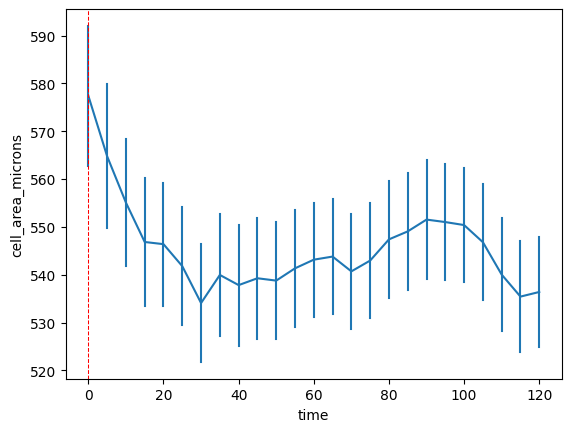

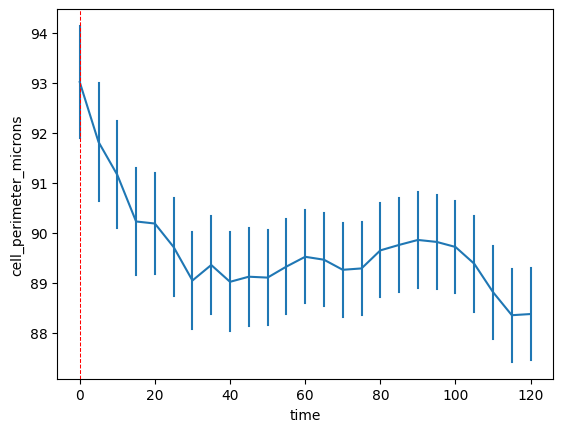

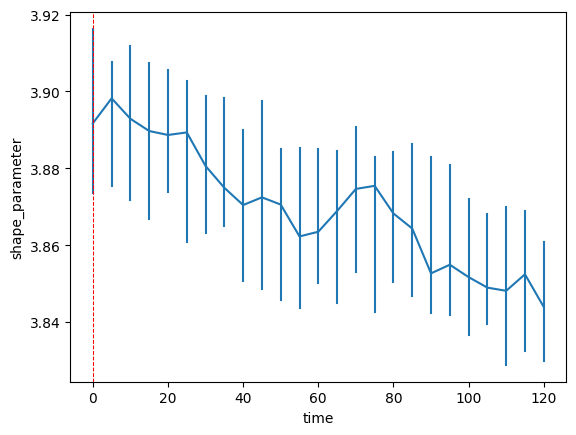

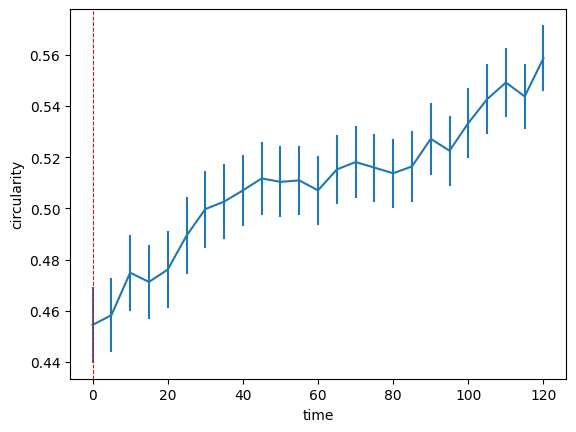

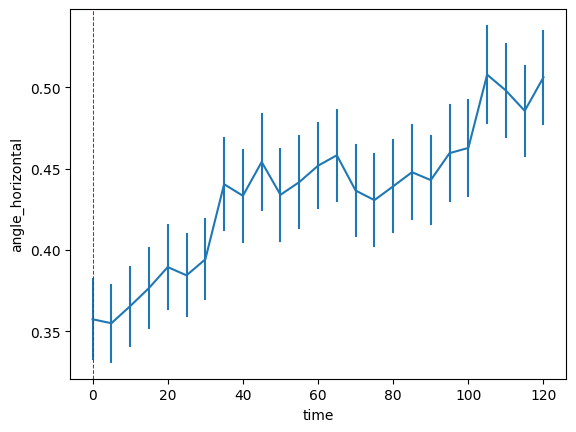

In [40]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

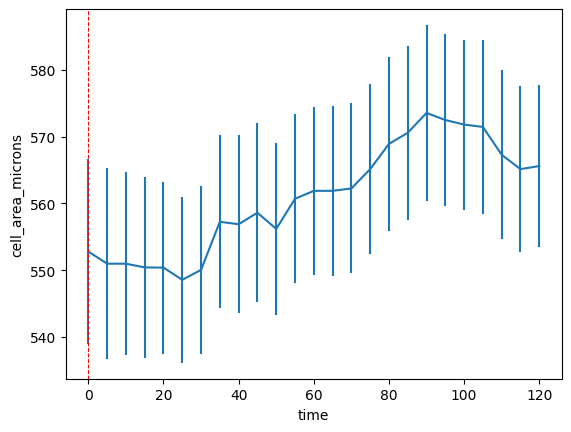

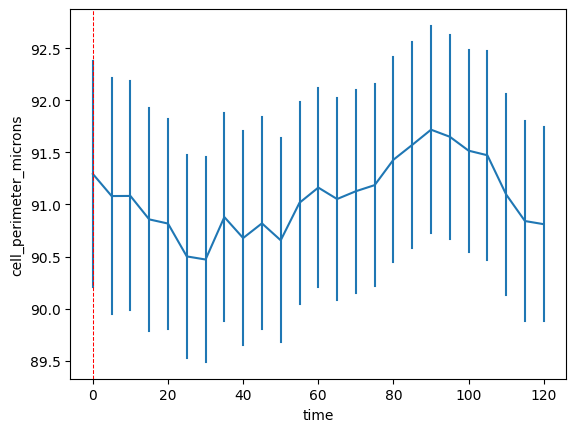

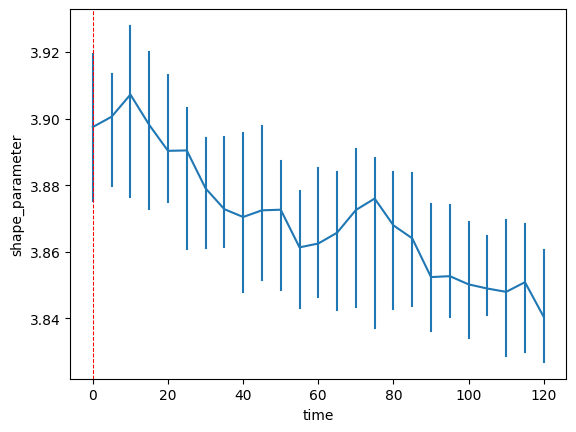

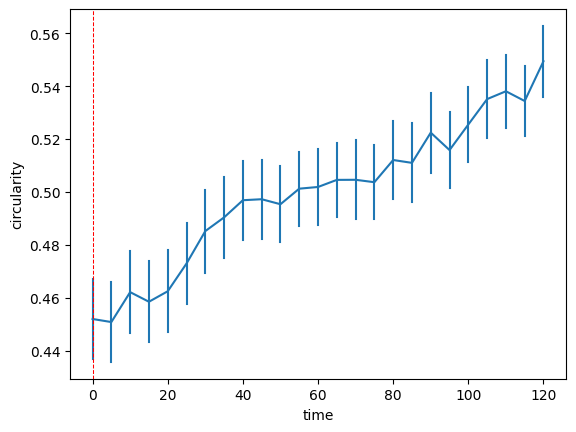

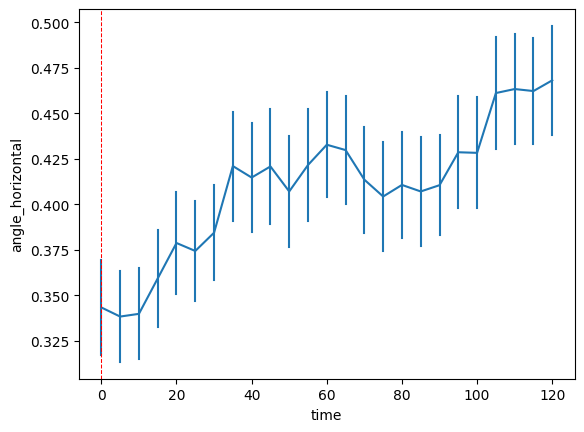

In [41]:
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

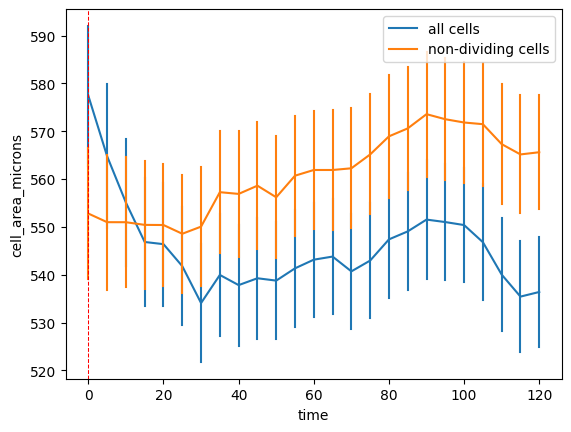

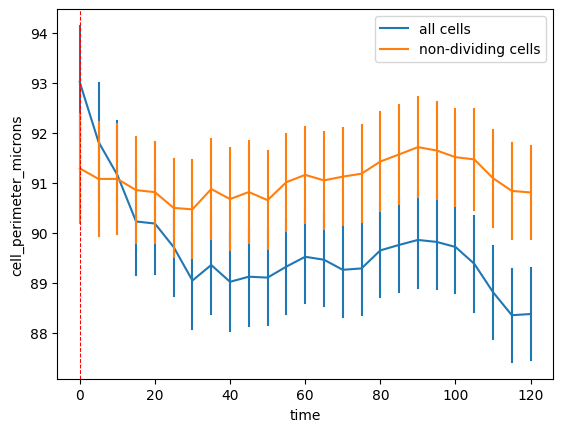

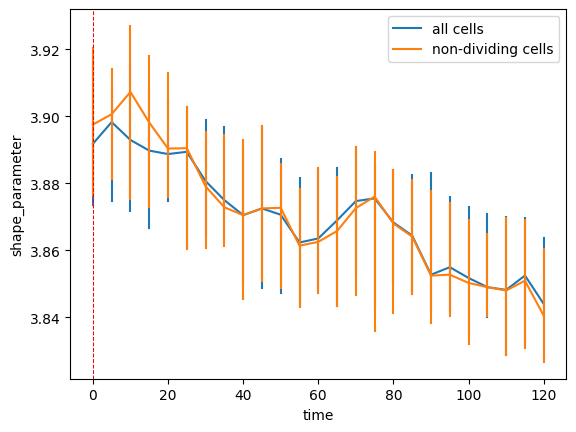

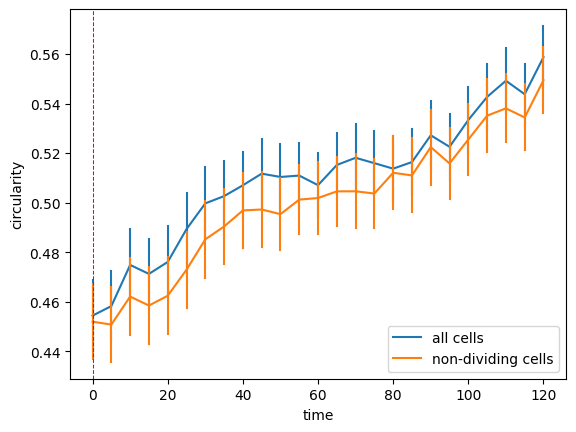

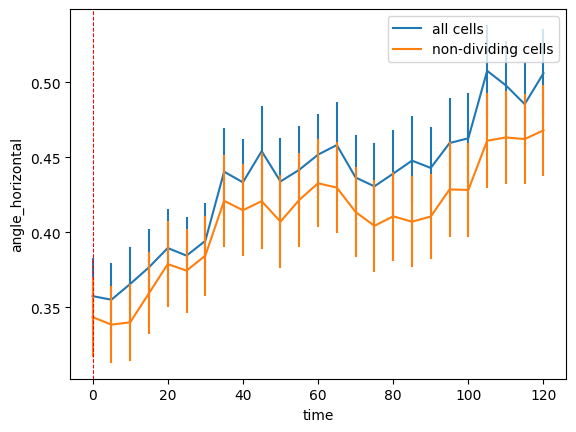

In [42]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median', label='all cells')
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median', label='non-dividing cells')
plt.legend()
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

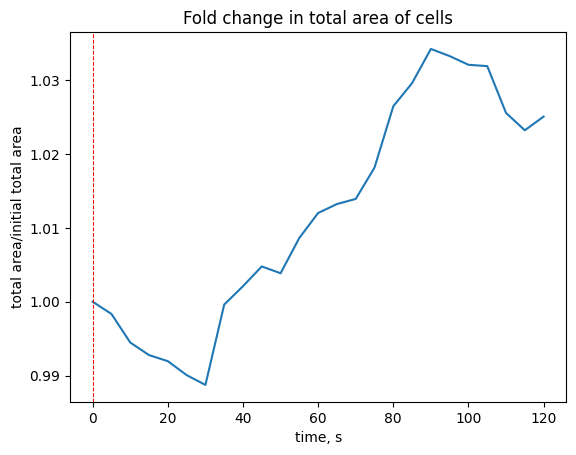

In [43]:
t=np.linspace(0, 120, 25)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==0].sum().cell_area_microns))
plt.axvline(0, linestyle='--', color='red', linewidth=0.75)
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

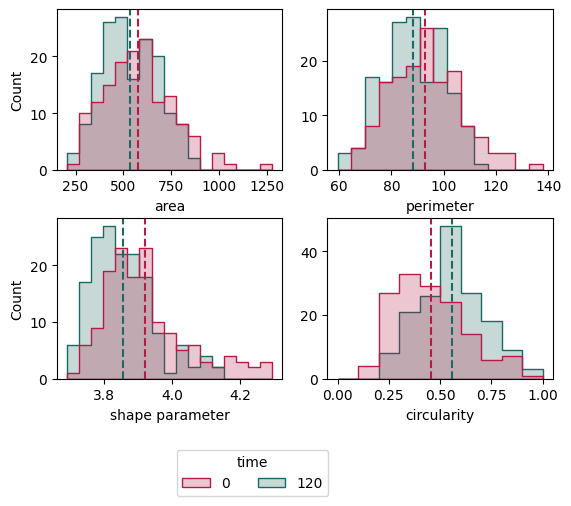

In [44]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=dat_df[(dat_df.time ==0) |  (dat_df.time==120)], hue='time',x='cell_area_microns', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[0,0], legend=False)
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==0].cell_area_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==120].cell_area_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) |  (dat_df.time==120)], hue='time',x='cell_perimeter_microns', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[0,1], legend=False)
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==0].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==120].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==120)], hue='time',x='circularity', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[1,1], legend=False , binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==0].circularity), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==120].circularity), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==120)], hue='time',x='shape_parameter', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[1,0], legend=True)
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==0].shape_parameter), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==120].shape_parameter), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -0.4), frameon=True, ncol=2)

plt.savefig(plot_dir+'/cell_quantities_hists.png', dpi=300, bbox_inches='tight')

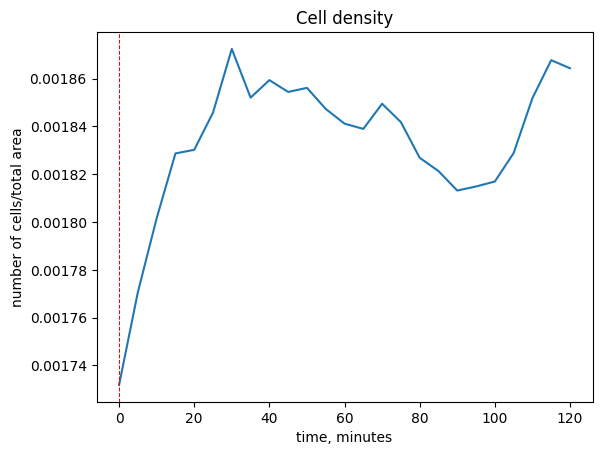

In [45]:
#cell density
plt.plot(dat_df.groupby('time').count().cell_id_new/(dat_df.groupby('time').cell_area_microns.sum()))
plt.axvline(0, c='r', linestyle='--', linewidth=0.75)

plt.xlabel('time, minutes')
plt.ylabel('number of cells/total area')
plt.title("Cell density")

plt.savefig(plot_dir+'/cell_density_time.png', dpi=300, bbox_inches='tight')

In [46]:
daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_30248\2948227597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')


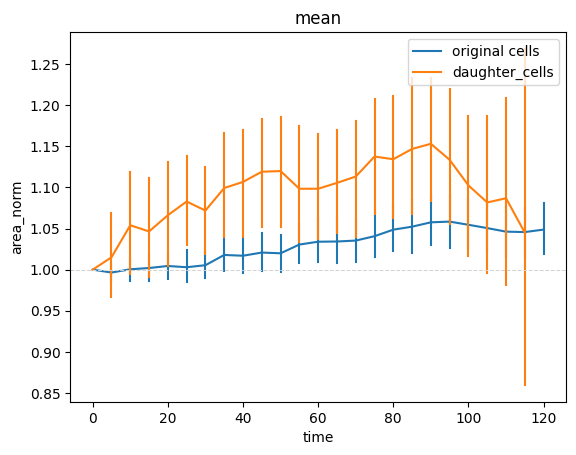

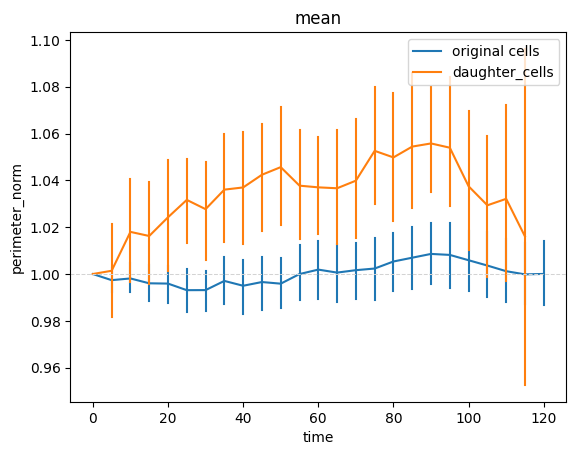

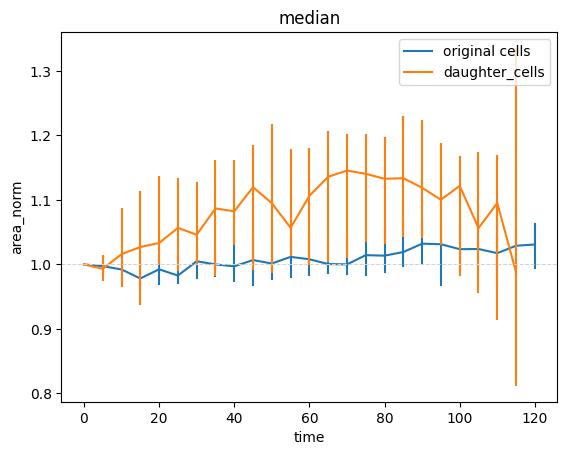

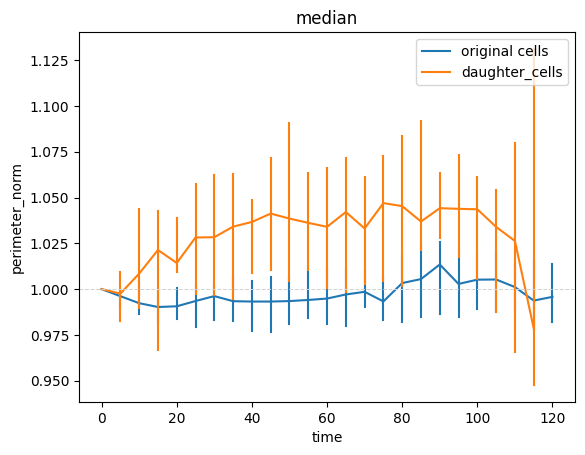

In [49]:

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('mean')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('mean')
plt.legend()
plt.savefig(plot_dir+'/mean_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells', estimator='median')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', estimator='median',label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars', estimator='median', label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars',estimator='median', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()